# Inleiding

In deze notebook ga je aan de hand van kennis uit drie onderdelen van het dataprocessen zelf data processing toepassen op een data set. In de onderstaande onderdelen worden steeds datasets gebruikt uit de pydataset package. De beschrijving van de data is ook steeds bij de data te vinden.

### Alle benodigde packages en functies eerst inladen

In [22]:
import pandas as pd                
import numpy as np 
from numpy.linalg import eigvals
from pydataset import data          
import matplotlib                    
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import cluster
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler,MaxAbsScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import average_precision_score

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline        

# 1. Schalen

Schalen heeft zijn toepassingen in zowel regressie als classificatie modellen. Het is belangrijk om te begrijpen wat schalen met de data doet voordat je conclusies kunt trekken uit je resultaten. Het doel is om inzicht te krijgen wat de effecten van schalen zijn.

We gebruiken hier de 'mtcars' dataset. Een set variabelen van verschillende Amerikaanse auto's. We gaan er hier vanuit dat 'mpg' de afhankelijke variabele is.

In [23]:
df_cars = data('mtcars')

In [24]:
df_cars.head(5)

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


- [, 1]	mpg	Miles/(US) gallon
- [, 2]	cyl	Number of cylinders
- [, 3]	disp	Displacement (cu.in.)
- [, 4]	hp	Gross horsepower
- [, 5]	drat	Rear axle ratio
- [, 6]	wt	Weight (1000 lbs)
- [, 7]	qsec	1/4 mile time
- [, 8]	vs	V/S
- [, 9]	am	Transmission (0 = automatic, 1 = manual)
- [,10]	gear	Number of forward gears
- [,11]	carb	Number of carburetors

Als we naar de ranges kijken van de afhankelijke variabelen dan vallen vooral 'hp' en 'disp' ver buiten de ranges van de andere variabelen

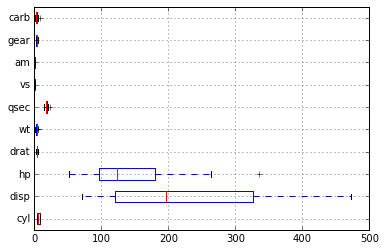

In [25]:
df_cars.drop('mpg',1).boxplot(vert=False); # Puntkomma zorgt ervoor dat matplotlib geen tekst output, maar alleen het plot

Omdat we hier naar de invloed van de features kijken om het brandstofgebruik te verklaren passen we hier standaardisatie toe om de features te schalen. Hieronder staan verschillende technieken:
- MinMaxScaler
- StandardScaler
- RobustScaler
- MaxAbsScaler

In [26]:
#Functie om dataframe te scalen en weer als dataframe te behouden
def schaal_df(df,scaler):
    for label in df.columns.values:
        df[label] = scaler.fit_transform(df[label])
    return df

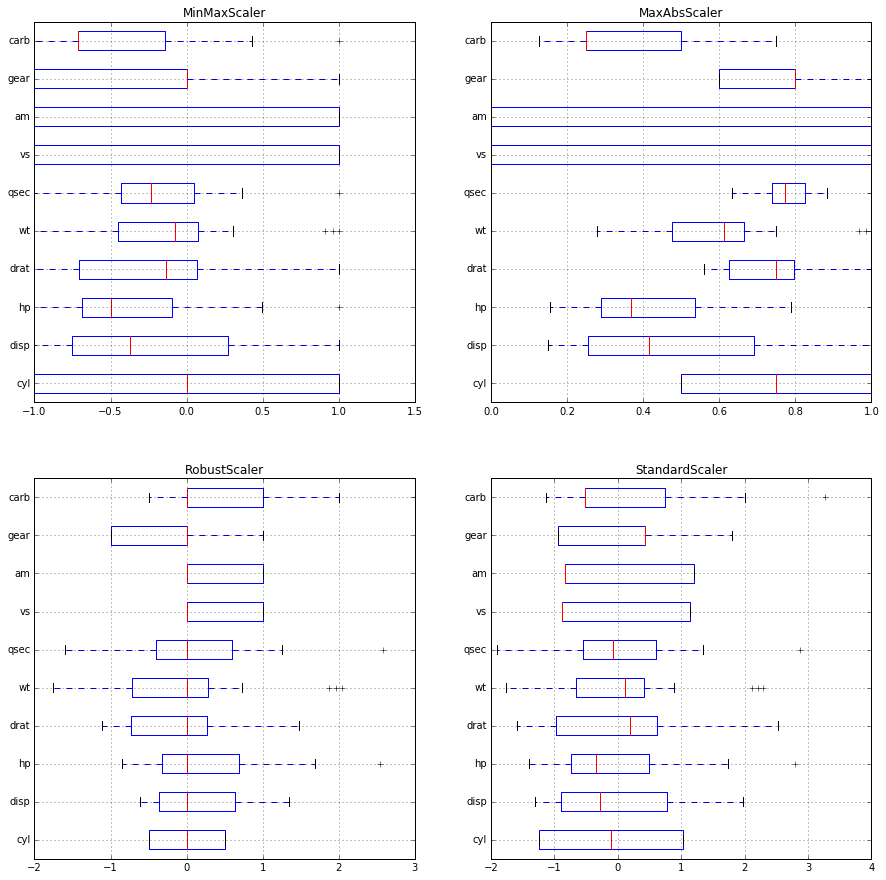

In [27]:
df_cars_minmax = schaal_df(df_cars.drop('mpg',1),MinMaxScaler((-1,1)))
df_cars_stands = schaal_df(df_cars.drop('mpg',1),StandardScaler())
df_cars_robust = schaal_df(df_cars.drop('mpg',1),RobustScaler())
df_cars_maxabs = schaal_df(df_cars.drop('mpg',1),MaxAbsScaler())

plt.figure(figsize=(15,15))
plt.subplot(221)
plt.title('MinMaxScaler')
df_cars_minmax.boxplot(vert=False);
plt.subplot(222)
plt.title('MaxAbsScaler')
df_cars_maxabs.boxplot(vert=False);
plt.subplot(223)
plt.title('RobustScaler')
df_cars_robust.boxplot(vert=False);
plt.subplot(224)
plt.title('StandardScaler')
df_cars_stands.boxplot(vert=False);

Bekijk nu zelf wat er bijvoorbeeld gebeurt met de dummy variabele als 'am'/'vs' en ordinale variabelen als 'gear'/'carb'

# 2. Dimensiereductie/clustering

Om dimensiereductie toe te passen moet je vrijwel altijd schalen. Dimensiereductie is zeer afhankelijk van de ranges waarop de features bestaan. Features met zeer grote waarden krijgen automatisch veel meer gewicht, maar hebben niet per se meer invloed. Het doel van dit onderdeel is om de invloeden van schalen op dimensiereductie te zien en hoe je bepaalt hoeveel componenten je uiteindelijk het beste kan gebruiken. We zullen hier slechts gebruik maken van de meest toegepaste techniek PCA (Principal Component Analysis), andere technieken zijn vooral in specifieke gevallen beter toepasbaar.

Om te bepalen wat een goede keuze is voor het aantal dimensies om je data naar terug te brengen kijken we naar het percentage behouden variantie in de features. Om dit te bepalen berekenen we de som van alle eigenwaarden van de covariantiematrix van de originele dataset af te zetten dit af tegen de som van eigenwaarden van de covariantiematrix van de gereduceerde dataset. Door deze data te plotten per n-components is inzichtelijk te maken bij hoeveel features de data nog welk deel van de variantie behoudt. 

In [28]:
# Functie om waarden voor plot te maken van verschillende PCA's van de data, inclusief threshold
def plot_val_pca(X,threshold=0.95, steps=1):
    pca_var = []
    total_range = range(1,X.shape[1]+1,steps) 
    for j in total_range:
        res = sum(eigvals(pd.DataFrame(PCA(n_components=j).fit_transform(X)).cov()))
        pca_var.append([j,res])
        if j == max(total_range):
            total_var = res
    pca_var = pd.DataFrame(pca_var)
    pca_var.columns = ['Components','Perc']
    pca_var['Perc'] = pca_var['Perc']/total_var
    pca_var.sort_values('Components',inplace=True)
    
    plt.plot(pca_var['Components'],pca_var['Perc'],'r',np.repeat(threshold,len(pca_var)),'k-.');

Als we de threshold op 95% van de behouden variantie zouden zetten dan zouden we bij ongeschaalde dataset van 'mtcars' met een totaal van 1 n_components PCA goed zitten

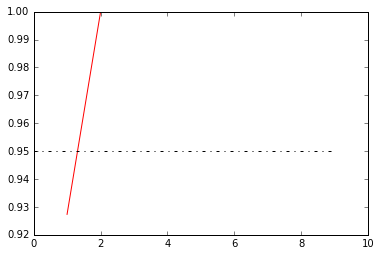

In [29]:
plot_val_pca(df_cars.drop('mpg',1),0.95)

Bekijk nu het verschil tussen de verschillende schalings technieken bij minimale threshold van 0.95

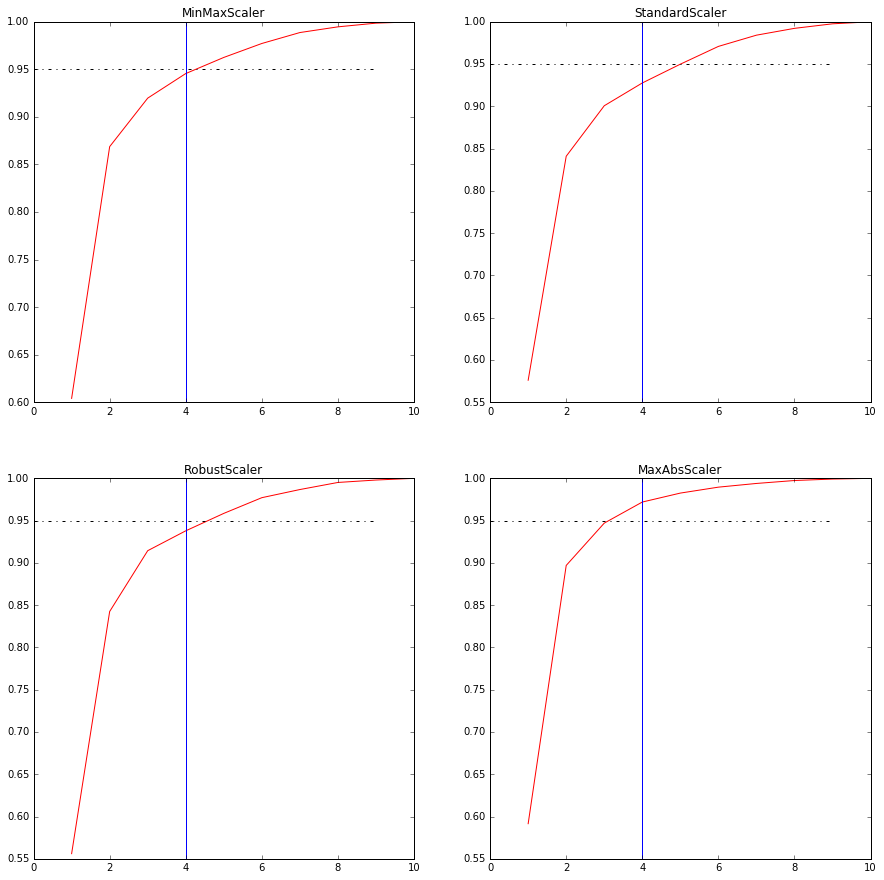

In [30]:
threshold = 0.95

plt.figure(figsize=(15,15))
plt.subplot(221)
plt.title('MinMaxScaler')
plot_val_pca(df_cars_minmax,threshold)
plt.axvline(4)
plt.subplot(222)
plt.title('StandardScaler')
plot_val_pca(df_cars_stands,threshold)
plt.axvline(4)
plt.subplot(223)
plt.title('RobustScaler')
plot_val_pca(df_cars_robust,threshold)
plt.axvline(4)
plt.subplot(224)
plt.title('MaxAbsScaler')
plot_val_pca(df_cars_maxabs,threshold)
plt.axvline(4)

Clustering is een techniek die je vaak nodig zult hebben als data scientist, omdat het veel toepassingen heeft in zowel classificatie- als regressiemodellen. In dit onderdeel bekijk je wat de invloeden van schalen en dimensiereductie zijn op clusteren. Ook ga je naar de verschillen tussen de verschillende clusteringtechnieken kijken.

Clustering pas je toe in de dimensies waarin de data bestaat. Om de clustering te kunnen visualiseren pas je nog eens dimensie reductie toe naar 2 of 3 componenten.

In [31]:
# Functie om clustering te maken en te visualiseren, inclusief aantal componenten om dimensiereductie toe te passen 
# en ook de outputvisualisatie in 2 of 3 dimensies. Dit is nu standaard 2
def vis_cluster(df,componenten,cluster_techniek,dimensie_2 = 2):
    X = PCA(componenten).fit_transform(df)
    cluster_X = cluster_techniek.fit_predict(X)
    X_vis =  PCA(dimensie_2).fit_transform(X)
    if dimensie_2 == 2:

        plt.scatter(X_vis[:,0],X_vis[:,1], c=cluster_X)
        
    else:
        plt.figure().add_subplot(111, projection='3d').scatter(X_vis[:,0],X_vis[:,1], zs = X_vis[:,2] , c=cluster_X)
        
    plt.xlabel('Totaal aantal clusters: ' + str(max(cluster_X)+1))

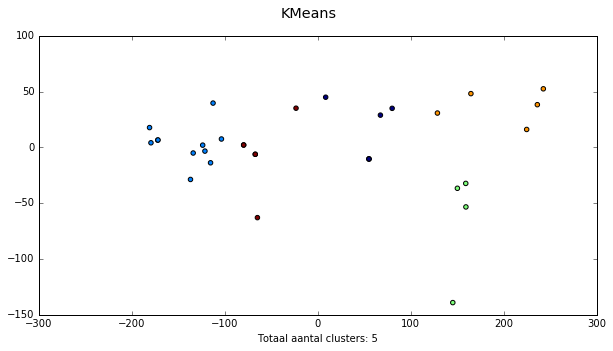

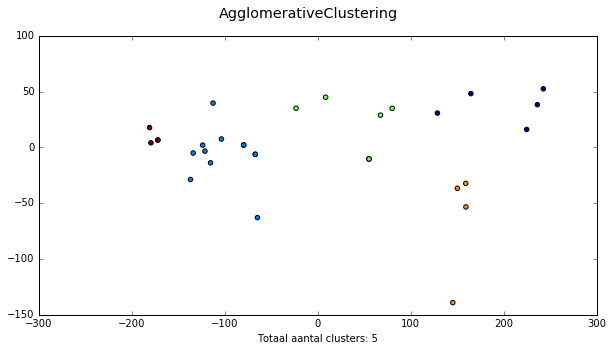

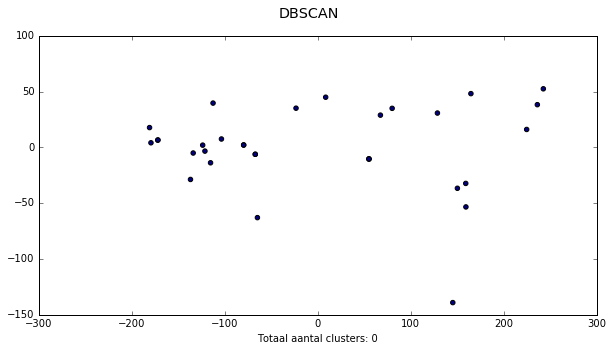

In [32]:
# Clustering zonder schaling maar wel met dimensiereductie vooraf
plt.figure(figsize=(10,5)).suptitle('KMeans', fontsize="x-large")
vis_cluster(df_cars.drop('mpg',1),4,KMeans(5))
plt.figure(figsize=(10,5)).suptitle('AgglomerativeClustering', fontsize="x-large")
vis_cluster(df_cars.drop('mpg',1),4,AgglomerativeClustering(5))
plt.figure(figsize=(10,5)).suptitle('DBSCAN', fontsize="x-large")
vis_cluster(df_cars.drop('mpg',1),4,DBSCAN())

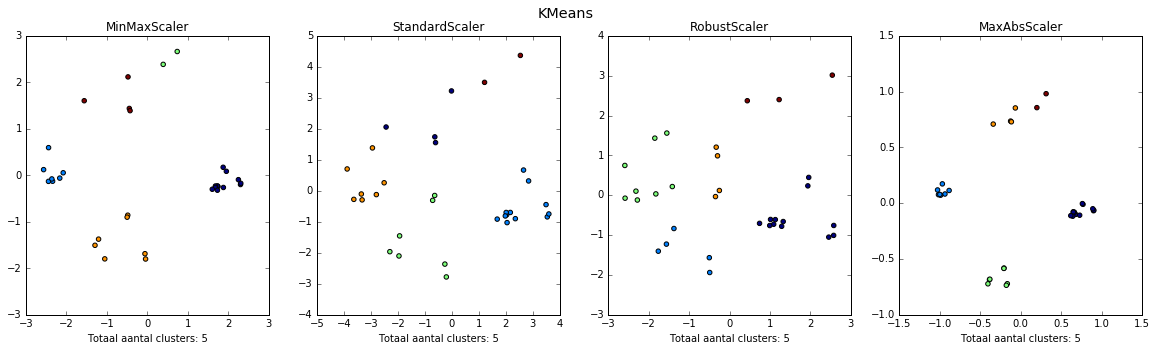

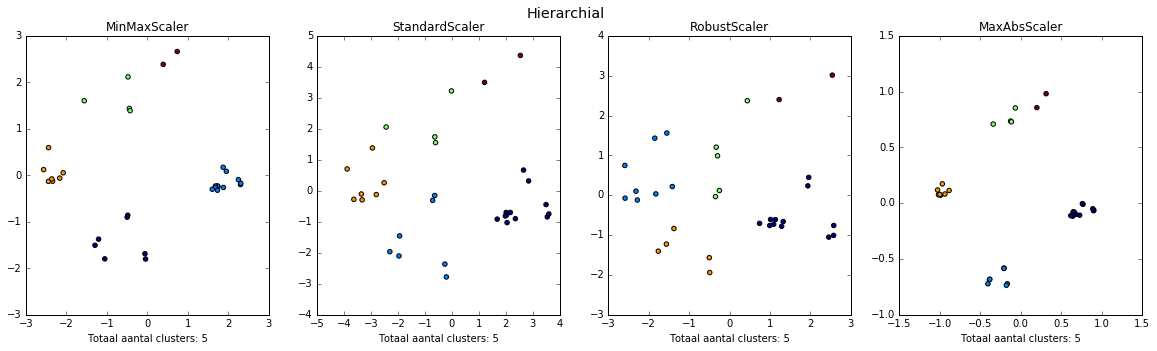

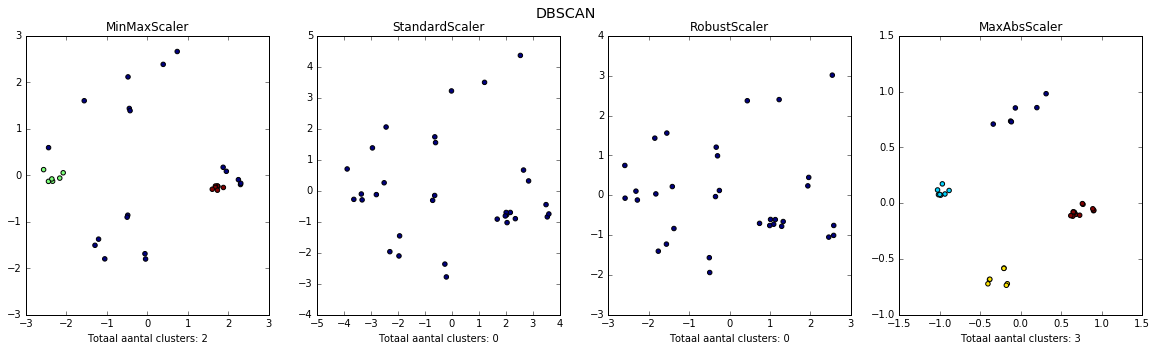

In [33]:
plt.figure(figsize=(20,5)).suptitle('KMeans', fontsize="x-large")
plt.subplot(141)
plt.title('MinMaxScaler')
vis_cluster(df_cars_minmax,4,KMeans(5))
plt.subplot(142)
plt.title('StandardScaler')
vis_cluster(df_cars_stands,5,KMeans(5))
plt.subplot(143)
plt.title('RobustScaler')
vis_cluster(df_cars_robust,5,KMeans(5))
plt.subplot(144)
plt.title('MaxAbsScaler')
vis_cluster(df_cars_maxabs,4,KMeans(5))

plt.figure(figsize=(20,5)).suptitle('Hierarchial', fontsize="x-large")
plt.subplot(141)
plt.title('MinMaxScaler')
vis_cluster(df_cars_minmax,4,AgglomerativeClustering(5))
plt.subplot(142)
plt.title('StandardScaler')
vis_cluster(df_cars_stands,5,AgglomerativeClustering(5))
plt.subplot(143)
plt.title('RobustScaler')
vis_cluster(df_cars_robust,5,AgglomerativeClustering(5))
plt.subplot(144)
plt.title('MaxAbsScaler')
vis_cluster(df_cars_maxabs,4,AgglomerativeClustering(5))

plt.figure(figsize=(20,5)).suptitle('DBSCAN', fontsize="x-large")
plt.subplot(141)
plt.title('MinMaxScaler')
vis_cluster(df_cars_minmax,5,DBSCAN())
plt.subplot(142)
plt.title('StandardScaler')
vis_cluster(df_cars_stands,4,DBSCAN())
plt.subplot(143)
plt.title('RobustScaler')
vis_cluster(df_cars_robust,5,DBSCAN())
plt.subplot(144)
plt.title('MaxAbsScaler')
vis_cluster(df_cars_maxabs,4,DBSCAN())

De DBSCAN vindt geen clusters bij de standard- en robustscaler. Bekijk de plots en speel wat met de instellingen om wat gevoel te krijgen bij de data.

NB: Je ziet dat zelfs bij een beperkt aantal technieken het aantal te analyseren gegevens snel explodeert, zorg daarom ook altijd voor een goed plan van aanpak voordat je aan de slag gaat met je data.

# 3. Extra features

Soms zijn er onvoldoende features, zoals in het voorbeeld uit de slides. Een ander voorbeeld is timeseries data. Door het sequentiële karakter van de data, zijn observaties uit het verleden vaak gerelateerd aan observaties nu. Om deze invloeden te beschrijven kunnen we bijvoorbeeld lags of windows toevoegen.
Op deze manier kun je oneindig veel extra features genereren.

In [34]:
df_sunspots = data('sunspots')

In [35]:
df_sunspots.head(5)

,time,sunspots
1,1749.000000,58.0
2,1749.083333,62.6
3,1749.166667,70.0
4,1749.250000,55.7
5,1749.333333,85.0


In [36]:
# Data herstructurering
df_sunspots['jaar'] = df_sunspots['time'].apply(lambda x: int(x))
df_sunspots['maand'] = df_sunspots['time'].apply(lambda x: str(x-int(x))[1:]).astype(float)
df_sunspots['maand'] = df_sunspots['maand'].apply(lambda x: int(x*12)+1)
df_sunspots['datum'] = pd.to_datetime(df_sunspots['jaar'].map(str)+'-'+df_sunspots['maand'].map(str),format = '%Y-%m')
df_sunspots.drop(['jaar','maand','time'],1,inplace = True)
df_sunspots.set_index('datum',inplace = True)

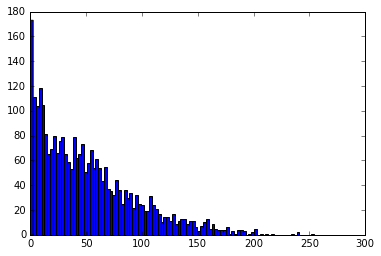

In [37]:
plt.hist(df_sunspots['sunspots'],bins=100);

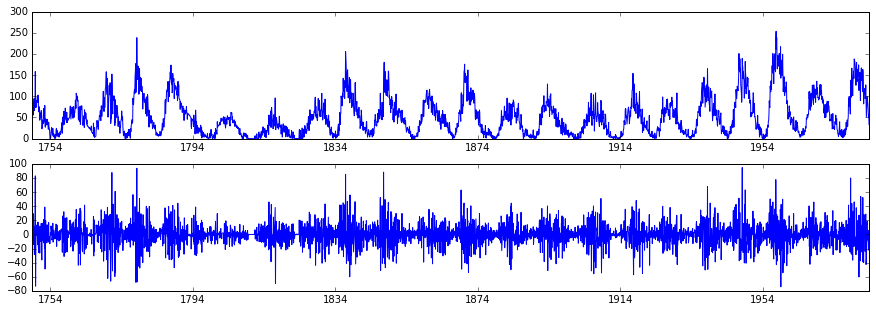

In [38]:
#basic plot + diff plot
plt.figure(figsize = (15,5))
plt.subplot(211)
plt.plot(df_sunspots['sunspots'])
plt.subplot(212)
plt.plot(df_sunspots['sunspots'].diff())

In [39]:
#Functie om ACF (autocorrelatie) te plotten van een timeseries, incl. normaal CI's (confidence intervals)
def plot_acf(ts):
    a = [ts.autocorr(i) for i in range(1,32)]
    plt.plot(a)
    plt.axhline(y=-1.96*np.std(a)/np.sqrt(len(a)),linestyle='--',color='gray')
    plt.axhline(y=1.96*np.std(a)/np.sqrt(len(a)),linestyle='--',color='gray')

Kijken of er indicatie is dat er lags zijn die invloed hebben

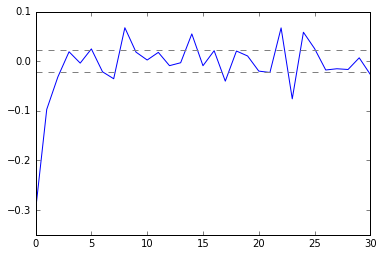

In [41]:
plot_acf(df_sunspots['sunspots'].diff());

Zo te zien zijn er een aantal lags zeker interessant. Niet direct iets periodieks te herkennen

In [42]:
#Functie om lags toe te voegen
def voegtoe_lag(df,ts,lags):
    for i in range(1,lags):
        df[str(ts)+'_lag_'+str(i)] = df[ts].shift(i)

In [43]:
#Functies om windows toe te voegen
def voegtoe_mean_window(df,ts,aantal_windows):
    for i in aantal_windows:
        df[str(ts)+'_mean_'+str(i)] = pd.rolling_mean(df[ts],i)
        
def voegtoe_std_window(df,ts,aantal_windows):
    for i in aantal_windows:
        df[str(ts)+'_std_'+str(i)] = pd.rolling_std(df[ts],i)

In [44]:
#Functie om polynominals toe te voegen. Poly geeft aan welke orde polynominals toegevoegd moeten worden
def voegtoe_poly(df,poly=1):
    all_columns = df.columns.values
    for col in all_columns:
        rest_col = all_columns[1:]
        for column in rest_col:
            for i in range(1,poly+1):
                for j in range(1,poly+1):
                    if col != column:
                        df[str(col)+'^'+str(i)+"_"+str(column)+'^'+str(j)] = (df[col]**i)*(df[column]**j)

In [45]:
#Genereer features
voegtoe_lag(df_sunspots,'sunspots',3)
voegtoe_poly(df_sunspots,2)
voegtoe_mean_window(df_sunspots,'sunspots',range(1,5))
voegtoe_std_window(df_sunspots,'sunspots',range(2,5))

In [46]:
#Verwijder NaN en bekijk resultaat
df_sunspots.dropna(inplace=True)
df_sunspots.head(5)

,sunspots,sunspots_lag_1,sunspots_lag_2,sunspots^1_sunspots_lag_1^1,sunspots^1_sunspots_lag_1^2,sunspots^2_sunspots_lag_1^1,sunspots^2_sunspots_lag_1^2,sunspots^1_sunspots_lag_2^1,sunspots^1_sunspots_lag_2^2,sunspots^2_sunspots_lag_2^1,...,sunspots_lag_2^1_sunspots_lag_1^2,sunspots_lag_2^2_sunspots_lag_1^1,sunspots_lag_2^2_sunspots_lag_1^2,sunspots_mean_1,sunspots_mean_2,sunspots_mean_3,sunspots_mean_4,sunspots_std_2,sunspots_std_3,sunspots_std_4
datum,,,,,,,,,,,,,,,,,,,,,
1749-04-01 00:00:00,55.7,70.0,62.6,3899.00,272930.000,217174.300,1.520220e+07,3486.82,218274.932,194215.874,...,306740.00,274313.20,19201924.00,55.7,62.85,62.766667,61.575,10.111627,7.151457,6.306808
1749-05-01 00:00:00,85.0,55.7,70.0,4734.50,263711.650,402432.500,2.241549e+07,5950.00,416500.000,505750.000,...,217174.30,272930.00,15202201.00,85.0,70.35,70.233333,68.325,20.718229,14.651394,12.556904
1749-06-01 00:00:00,83.5,85.0,55.7,7097.50,603287.500,592641.250,5.037451e+07,4650.95,259057.915,388354.325,...,402432.50,263711.65,22415490.25,83.5,84.25,74.733333,73.550,1.060660,16.500404,13.678816
1749-07-01 00:00:00,94.8,83.5,85.0,7915.80,660969.300,750417.840,6.265989e+07,8058.00,684930.000,763898.400,...,592641.25,603287.50,50374506.25,94.8,89.15,87.766667,79.750,7.990307,6.137046,16.798115
1749-08-01 00:00:00,66.3,94.8,83.5,6285.24,595840.752,416711.412,3.950424e+07,5536.05,462260.175,367040.115,...,750417.84,660969.30,62659889.64,66.3,80.55,81.533333,82.400,20.152543,14.351423,11.845393


Bekijk nu met dimensiereductie hoe de variantie verandert met het aantal componenten

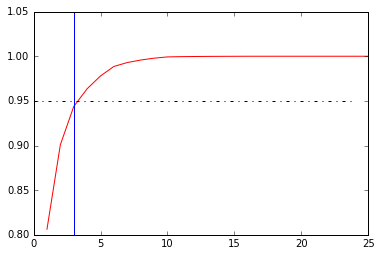

In [47]:
plot_val_pca(schaal_df(df_sunspots,StandardScaler()).drop('sunspots',1),0.95)
plt.axvline(3)

Ergens rond de 3 components is nog steeds 95% aanwezig van alle variantie opgespannen door alle geëngineerde features. Waarom is dit ook logisch?

Speel met het aantal features dat je genereert en hoe het aantal componenten dan wijzigt bij 95% threshold

# 4. Zelf aan de slag!

Pas de kennis die je opgedaan hebt in de vorige onderdelen toe bij de volgende 2 datasets. Voor elke dataset moet je specifieke vragen oplossen. Je zult de data zelf ook nog moeten preprocessen. Denk daarbij ook aan de stappen die we gisteren hebben besproken.

## 4a. Titanic

De 'titanic' dataset is een classificatie dataset, of iemand de ramp overleeft heeft of niet. Maak op basis van de features een KMeans clustering. Vragen:
 1. Hoeveel observaties zitten er in de dataset
 2. Hoeveel personen zitten er in elke classe?
 3. Wat is de verdeling (percentage) mannen/vrouwen en volwassenen/kinderen in de data set
 4. Waarom moet je wel of niet schalen?
 5. Wat is een logische keuze voor het aantal clusters? Visualiseer de clusters.
 6. Maak de clustering en koppel dit terug aan de data. Hoe goed voorspelt de clustering de overlevingskans? Gebruik hiervoor de juiste metrics. Bijvoorbeeld de average_precision_score. Je hoeft de data hier nog niet op te splitsen in train/test.
 7. Wat zou je nog kunnen doen om de clustering accurater te maken? Andere clustering? (Andere) schaling? Feature engineering/generation? Probeer de score van de KMeans clustering te verbeteren.

### 0. Inladen Dataset 

In [6]:
df_titanic = data('titanic')
df_titanic.head(5)

,class,age,sex,survived
1,1st class,adults,man,yes
2,1st class,adults,man,yes
3,1st class,adults,man,yes
4,1st class,adults,man,yes
5,1st class,adults,man,yes


In [27]:
# 1
# 2
# 3
# 4
# 5
# 6
# 7

# 4b. Basebal

Deze dataset vereist wat meer processing. Ga het onderstaande lijstje af en motiveer waarom je bepaalde keuzes maakt:
 1. Wat voor datatypen zitten er in de set
 2. Wat zijn de vullingsgraden
 3. Pas de lege waarden aan of verwijder deze (Motiveer)
 4. Transformeer tekst kolommen of verwijder deze (Motiveer)
 5. Pas Dimensie Reductie toe en/of Voeg extra variabelen toe

In [53]:
df_base = data('baseball')

### Beschrijving dataset

This data frame contains batting statistics for a subset of players collected from http://www.baseball-databank.org/. There are a total of 21,699 records, covering 1,228 players from 1871 to 2007. Only players with more 15 seasons of play are included.

- id, unique player id

- year, year of data

- stint, player nth time same player in database

- team, team played for

- lg, league

- g, number of games

- ab, number of times at bat

- r, number of runs

- h, hits, times reached base because of a batted, fair ball without error by the defense

- X2b, hits on which the batter reached second base safely

- X3b, hits on which the batter reached third base safely

- hr, number of home runs

- rbi, runs batted in

- sb, stolen bases

- cs, caught stealing

- bb, base on balls (walk)

- so, strike outs

- ibb, intentional base on balls

- hbp, hits by pitch

- sh, sacrifice hits

- sf, sacrifice flies

- gidp, ground into double play

In [32]:
# 1
# 2
# 3
# 4
# 5

Soms weet je hoeveel clusters je wilt hebben, maar meestal is dit onbekend. Een manier voor KMeans om het aantal clusters te bepalen is de elbow method (wiki). Zoek waar een duidelijke knik in de grafiek zit, die index +1 is je aantal clusters. 

In [33]:
#functie voor elbow methode voor kmeans
def elbow_kmeans(df):
    initial = [cluster.vq.kmeans(df,i) for i in range(1,10)]
    plt.plot([var for (cent,var) in initial])
    plt.show()

 6. Cluster de data -> maak wat plots
 7. Wat voor eigenschappen zitten er in elke cluster? Bedenk hoe je dit kunt visualiseren.